In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [2]:
from cepha_rfrv import (
    CephalometricDataLoader,
    ImagePreprocessor,
    HaarFeatureExtractor,
    RFRVTrainer,
    OptimizedRFRVDetector
)

In [3]:
# Random seed for reproducibility
np.random.seed(42)

In [4]:
# Paths
ANNOTATIONS_PATH = r"C:\Users\victo\Downloads\OneDrive_2025-10-02\Dataset Kaggle\Annotations"
IMAGES_PATH = r"C:\Users\victo\Downloads\OneDrive_2025-10-02\Dataset Kaggle\Cephalograms"

# Data split
TEST_SPLIT = 0.2  # 20% for testing, 80% for training

# Preprocessing
REFERENCE_WIDTH = 800  # Normalize images to this width

# Feature extraction
PATCH_SIZE = 24       # Size of patches for Haar features
NUM_FEATURES = 100    # Number of Haar features

# Training parameters
MAX_DISPLACEMENT = 100     # Maximum displacement for training samples
SAMPLES_PER_IMAGE = 100  # Number of training samples per landmark per image
N_TREES = 30              # Number of trees in Random Forest (more = better but slower)
MAX_DEPTH = 20            # Maximum tree depth

# Detection parameters
USE_COARSE_TO_FINE = True  # Use fast coarse-to-fine detection
COARSE_STEP = 15          # Step size for coarse detection
FINE_STEP = 3             # Step size for fine detection

# Output
MODEL_SAVE_PATH = "trained_rfrv_model_full.pkl"
RESULTS_CSV_PATH = "detection_results.csv"

STEP 1: LOADING DATA
Loading 400 samples...


100%|██████████| 400/400 [00:10<00:00, 36.43it/s]


Successfully loaded 400 samples

✓ Loaded 400 total images

Dataset Statistics:
  - Image dimensions: 1935×2400 pixels (average)
  - Number of landmarks: 19
  - Landmarks: A, ANS, Ar, B, Gn, Go, LIT, Li, Ls, Me, N, Or, PNS, Po, Pog, Pos, S, Sn, UIT


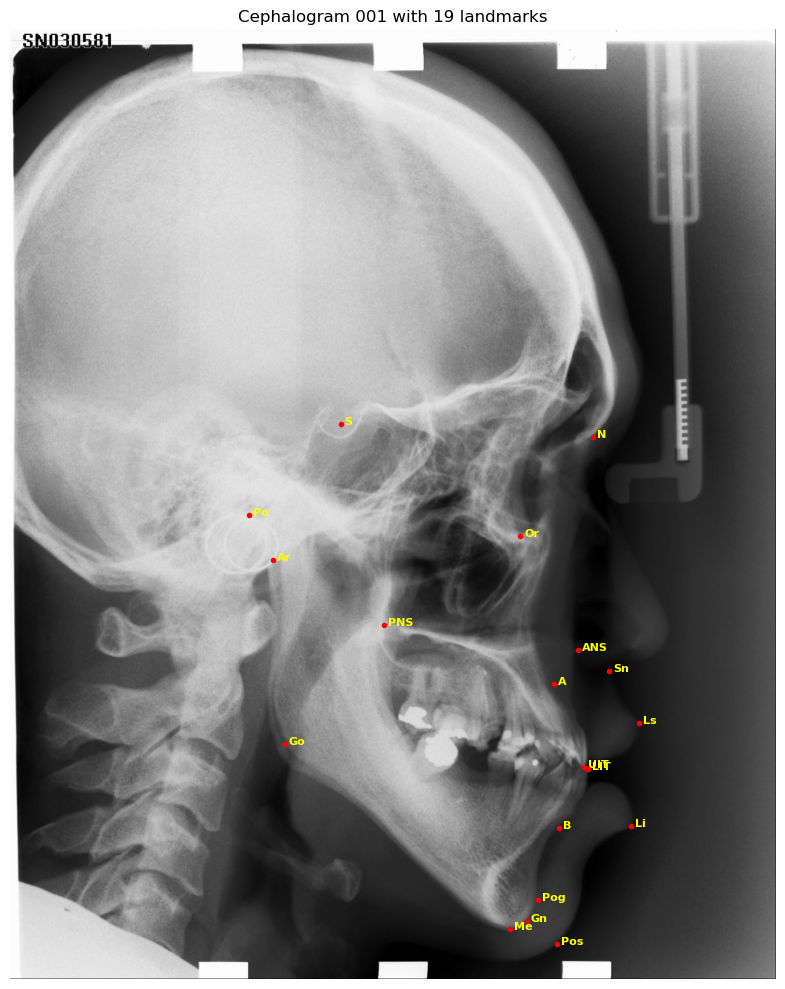

In [5]:
print("="*60)
print("STEP 1: LOADING DATA")
print("="*60)

# Initialize data loader
data_loader = CephalometricDataLoader(ANNOTATIONS_PATH, IMAGES_PATH)

# Load ALL data
all_data = data_loader.load_data(max_samples=None)  # None = load everything
print(f"\n✓ Loaded {len(all_data)} total images")

# Get statistics
stats = data_loader.get_statistics()
print(f"\nDataset Statistics:")
print(f"  - Image dimensions: {stats['image_widths']['mean']:.0f}×{stats['image_heights']['mean']:.0f} pixels (average)")
print(f"  - Number of landmarks: {stats['num_landmarks']}")
print(f"  - Landmarks: {', '.join(stats['landmarks'])}")

# Visualize first sample
data_loader.visualize_sample(0)

In [6]:
print("="*60)
print("STEP 2: TRAIN/TEST SPLIT")
print("="*60)

# Shuffle data for random split
np.random.shuffle(all_data)

# Split
split_idx = int(len(all_data) * (1 - TEST_SPLIT))
train_data = all_data[:split_idx]
test_data = all_data[split_idx:]

print(f"\n✓ Training set: {len(train_data)} images ({(1-TEST_SPLIT)*100:.0f}%)")
print(f"✓ Test set: {len(test_data)} images ({TEST_SPLIT*100:.0f}%)")

# Verify no overlap
train_ids = set([d['ceph_id'] for d in train_data])
test_ids = set([d['ceph_id'] for d in test_data])
assert len(train_ids.intersection(test_ids)) == 0, "Train and test sets overlap!"
print(f"✓ No overlap between train and test sets")

STEP 2: TRAIN/TEST SPLIT

✓ Training set: 320 images (80%)
✓ Test set: 80 images (20%)
✓ No overlap between train and test sets



STEP 3: PREPROCESSING

Preprocessing training data...
Preprocessing dataset...


100%|██████████| 320/320 [00:00<00:00, 1181.82it/s]


Common landmarks across all samples: ['A', 'ANS', 'Ar', 'B', 'Gn', 'Go', 'LIT', 'Li', 'Ls', 'Me', 'N', 'Or', 'PNS', 'Po', 'Pog', 'Pos', 'S', 'Sn', 'UIT']

Preprocessing test data...
Preprocessing dataset...


100%|██████████| 80/80 [00:00<00:00, 1377.87it/s]


Common landmarks across all samples: ['A', 'ANS', 'Ar', 'B', 'Gn', 'Go', 'LIT', 'Li', 'Ls', 'Me', 'N', 'Or', 'PNS', 'Po', 'Pog', 'Pos', 'S', 'Sn', 'UIT']

✓ Preprocessed 320 training images
✓ Preprocessed 80 test images
✓ Computed mean shape for 19 landmarks


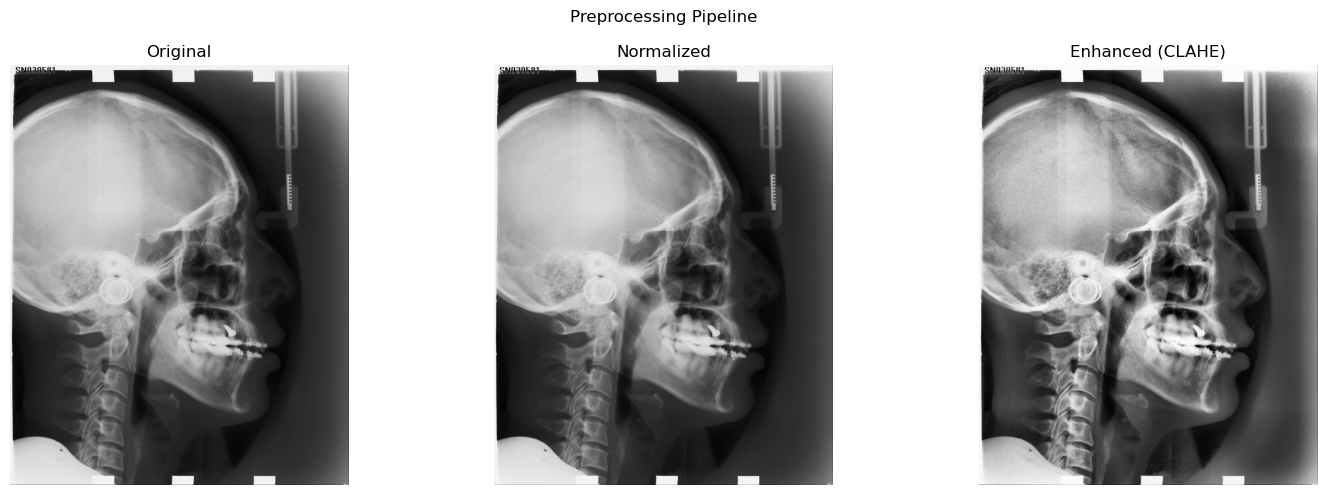

In [7]:
print("\n" + "="*60)
print("STEP 3: PREPROCESSING")
print("="*60)

# Initialize preprocessor
preprocessor = ImagePreprocessor(reference_width=REFERENCE_WIDTH)

# Preprocess both sets
print("\nPreprocessing training data...")
train_preprocessed = preprocessor.preprocess_dataset(train_data)

print("\nPreprocessing test data...")
test_preprocessed = preprocessor.preprocess_dataset(test_data)

print(f"\n✓ Preprocessed {len(train_preprocessed)} training images")
print(f"✓ Preprocessed {len(test_preprocessed)} test images")
print(f"✓ Computed mean shape for {len(preprocessor.landmark_keys)} landmarks")

# Visualize preprocessing effect
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sample_idx = 0
axes[0].imshow(train_data[sample_idx]['image'], cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(train_preprocessed[sample_idx]['normalized_image'], cmap='gray')
axes[1].set_title('Normalized')
axes[1].axis('off')

axes[2].imshow(train_preprocessed[sample_idx]['enhanced_image'], cmap='gray')
axes[2].set_title('Enhanced (CLAHE)')
axes[2].axis('off')

plt.suptitle('Preprocessing Pipeline')
plt.tight_layout()
plt.show()

In [8]:
print("\n" + "="*60)
print("STEP 4: FEATURE EXTRACTION SETUP")
print("="*60)

# Initialize feature extractor
feature_extractor = HaarFeatureExtractor(
    patch_size=PATCH_SIZE,
    num_features=NUM_FEATURES
)

print(f"\n✓ Initialized {NUM_FEATURES} Haar features")
print(f"✓ Patch size: {PATCH_SIZE}×{PATCH_SIZE} pixels")

# Test feature extraction
test_image = train_preprocessed[0]['enhanced_image']
test_landmark = list(train_preprocessed[0]['normalized_landmarks'].keys())[0]
test_pos = train_preprocessed[0]['normalized_landmarks'][test_landmark]
test_features = feature_extractor.extract_features(test_image, test_pos[0], test_pos[1])

print(f"\n✓ Feature extraction test:")
print(f"  - Extracted {len(test_features)} features")
print(f"  - Feature range: [{test_features.min():.2f}, {test_features.max():.2f}]")


STEP 4: FEATURE EXTRACTION SETUP

✓ Initialized 100 Haar features
✓ Patch size: 24×24 pixels

✓ Feature extraction test:
  - Extracted 100 features
  - Feature range: [-1683.00, 5436.00]


In [9]:
print("\n" + "="*60)
print("STEP 5: TRAINING RANDOM FOREST MODELS")
print("="*60)

# Initialize trainer
trainer = RFRVTrainer(
    feature_extractor=feature_extractor,
    max_displacement=MAX_DISPLACEMENT,
    num_samples_per_image=SAMPLES_PER_IMAGE
)

print(f"\nTraining Configuration:")
print(f"  - Max displacement: {MAX_DISPLACEMENT} pixels")
print(f"  - Samples per image: {SAMPLES_PER_IMAGE}")
print(f"  - Trees per forest: {N_TREES}")
print(f"  - Max tree depth: {MAX_DEPTH}")

# Start training timer
start_time = time.time()

# Train on all landmarks
trained_models = trainer.train_all_landmarks(
    train_preprocessed,
    landmark_keys=None  # None = train all landmarks
)

# Training time
training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time/60:.1f} minutes")
print(f"✓ Trained {len(trained_models)} landmark models")


STEP 5: TRAINING RANDOM FOREST MODELS

Training Configuration:
  - Max displacement: 100 pixels
  - Samples per image: 100
  - Trees per forest: 30
  - Max tree depth: 20

Training models for 19 landmarks...

Training landmark: A
Generating training samples for landmark 'A'...


100%|██████████| 320/320 [00:11<00:00, 27.21it/s]


Generated 32000 training samples for landmark 'A'
Training Random Forest for landmark 'A'...
  Training samples: 32000
  Features per sample: 100
  Number of trees: 10
  Training MAE: 23.62 pixels
  Training RMSE: 31.05 pixels

Training landmark: ANS
Generating training samples for landmark 'ANS'...


100%|██████████| 320/320 [00:11<00:00, 29.05it/s]


Generated 32000 training samples for landmark 'ANS'
Training Random Forest for landmark 'ANS'...
  Training samples: 32000
  Features per sample: 100
  Number of trees: 10
  Training MAE: 25.00 pixels
  Training RMSE: 32.90 pixels

Training landmark: Ar
Generating training samples for landmark 'Ar'...


100%|██████████| 320/320 [00:11<00:00, 27.31it/s]


Generated 32000 training samples for landmark 'Ar'
Training Random Forest for landmark 'Ar'...
  Training samples: 32000
  Features per sample: 100
  Number of trees: 10
  Training MAE: 26.23 pixels
  Training RMSE: 34.42 pixels

Training landmark: B
Generating training samples for landmark 'B'...


100%|██████████| 320/320 [00:11<00:00, 28.97it/s]


Generated 32000 training samples for landmark 'B'
Training Random Forest for landmark 'B'...
  Training samples: 32000
  Features per sample: 100
  Number of trees: 10
  Training MAE: 20.36 pixels
  Training RMSE: 26.86 pixels

Training landmark: Gn
Generating training samples for landmark 'Gn'...


100%|██████████| 320/320 [00:11<00:00, 28.91it/s]


Generated 31763 training samples for landmark 'Gn'
Training Random Forest for landmark 'Gn'...
  Training samples: 31763
  Features per sample: 100
  Number of trees: 10
  Training MAE: 20.57 pixels
  Training RMSE: 27.69 pixels

Training landmark: Go
Generating training samples for landmark 'Go'...


100%|██████████| 320/320 [00:11<00:00, 28.71it/s]


Generated 32000 training samples for landmark 'Go'
Training Random Forest for landmark 'Go'...
  Training samples: 32000
  Features per sample: 100
  Number of trees: 10
  Training MAE: 23.82 pixels
  Training RMSE: 30.74 pixels

Training landmark: LIT
Generating training samples for landmark 'LIT'...


100%|██████████| 320/320 [00:10<00:00, 29.11it/s]


Generated 32000 training samples for landmark 'LIT'
Training Random Forest for landmark 'LIT'...
  Training samples: 32000
  Features per sample: 100
  Number of trees: 10
  Training MAE: 19.78 pixels
  Training RMSE: 26.52 pixels

Training landmark: Li
Generating training samples for landmark 'Li'...


100%|██████████| 320/320 [00:10<00:00, 30.09it/s]


Generated 31882 training samples for landmark 'Li'
Training Random Forest for landmark 'Li'...
  Training samples: 31882
  Features per sample: 100
  Number of trees: 10
  Training MAE: 23.51 pixels
  Training RMSE: 31.84 pixels

Training landmark: Ls
Generating training samples for landmark 'Ls'...


100%|██████████| 320/320 [00:10<00:00, 30.52it/s]


Generated 31839 training samples for landmark 'Ls'
Training Random Forest for landmark 'Ls'...
  Training samples: 31839
  Features per sample: 100
  Number of trees: 10
  Training MAE: 24.11 pixels
  Training RMSE: 32.76 pixels

Training landmark: Me
Generating training samples for landmark 'Me'...


100%|██████████| 320/320 [00:10<00:00, 31.24it/s]


Generated 31577 training samples for landmark 'Me'
Training Random Forest for landmark 'Me'...
  Training samples: 31577
  Features per sample: 100
  Number of trees: 10
  Training MAE: 20.70 pixels
  Training RMSE: 27.95 pixels

Training landmark: N
Generating training samples for landmark 'N'...


100%|██████████| 320/320 [00:10<00:00, 30.64it/s]


Generated 31992 training samples for landmark 'N'
Training Random Forest for landmark 'N'...
  Training samples: 31992
  Features per sample: 100
  Number of trees: 10
  Training MAE: 21.52 pixels
  Training RMSE: 29.38 pixels

Training landmark: Or
Generating training samples for landmark 'Or'...


100%|██████████| 320/320 [00:10<00:00, 30.23it/s]


Generated 32000 training samples for landmark 'Or'
Training Random Forest for landmark 'Or'...
  Training samples: 32000
  Features per sample: 100
  Number of trees: 10
  Training MAE: 26.99 pixels
  Training RMSE: 34.10 pixels

Training landmark: PNS
Generating training samples for landmark 'PNS'...


100%|██████████| 320/320 [00:10<00:00, 30.38it/s]


Generated 32000 training samples for landmark 'PNS'
Training Random Forest for landmark 'PNS'...
  Training samples: 32000
  Features per sample: 100
  Number of trees: 10
  Training MAE: 25.93 pixels
  Training RMSE: 33.11 pixels

Training landmark: Po
Generating training samples for landmark 'Po'...


100%|██████████| 320/320 [00:10<00:00, 30.39it/s]


Generated 32000 training samples for landmark 'Po'
Training Random Forest for landmark 'Po'...
  Training samples: 32000
  Features per sample: 100
  Number of trees: 10
  Training MAE: 26.17 pixels
  Training RMSE: 33.75 pixels

Training landmark: Pog
Generating training samples for landmark 'Pog'...


100%|██████████| 320/320 [00:10<00:00, 30.68it/s]


Generated 31939 training samples for landmark 'Pog'
Training Random Forest for landmark 'Pog'...
  Training samples: 31939
  Features per sample: 100
  Number of trees: 10
  Training MAE: 20.26 pixels
  Training RMSE: 27.22 pixels

Training landmark: Pos
Generating training samples for landmark 'Pos'...


100%|██████████| 320/320 [00:10<00:00, 30.54it/s]


Generated 31623 training samples for landmark 'Pos'
Training Random Forest for landmark 'Pos'...
  Training samples: 31623
  Features per sample: 100
  Number of trees: 10
  Training MAE: 22.16 pixels
  Training RMSE: 29.31 pixels

Training landmark: S
Generating training samples for landmark 'S'...


100%|██████████| 320/320 [00:12<00:00, 26.37it/s]


Generated 32000 training samples for landmark 'S'
Training Random Forest for landmark 'S'...
  Training samples: 32000
  Features per sample: 100
  Number of trees: 10
  Training MAE: 24.55 pixels
  Training RMSE: 31.89 pixels

Training landmark: Sn
Generating training samples for landmark 'Sn'...


100%|██████████| 320/320 [00:10<00:00, 30.18it/s]


Generated 31974 training samples for landmark 'Sn'
Training Random Forest for landmark 'Sn'...
  Training samples: 31974
  Features per sample: 100
  Number of trees: 10
  Training MAE: 23.17 pixels
  Training RMSE: 31.36 pixels

Training landmark: UIT
Generating training samples for landmark 'UIT'...


100%|██████████| 320/320 [00:10<00:00, 30.12it/s]


Generated 31997 training samples for landmark 'UIT'
Training Random Forest for landmark 'UIT'...
  Training samples: 31997
  Features per sample: 100
  Number of trees: 10
  Training MAE: 20.65 pixels
  Training RMSE: 27.77 pixels

Training complete! Trained 19 models

✓ Training completed in 3.5 minutes
✓ Trained 19 landmark models


In [10]:
print("\n" + "="*60)
print("STEP 6: SAVING MODELS")
print("="*60)

# Save everything needed for inference
save_dict = {
    'trainer_models': trainer.rf_models,
    'feature_extractor': feature_extractor,
    'preprocessor_config': {
        'reference_width': preprocessor.reference_width,
        'mean_shape': preprocessor.mean_shape,
        'landmark_keys': preprocessor.landmark_keys
    },
    'training_config': {
        'max_displacement': MAX_DISPLACEMENT,
        'samples_per_image': SAMPLES_PER_IMAGE,
        'n_trees': N_TREES,
        'patch_size': PATCH_SIZE,
        'num_features': NUM_FEATURES
    },
    'training_stats': {
        'n_train_images': len(train_preprocessed),
        'n_test_images': len(test_preprocessed),
        'training_time': training_time
    }
}

with open(MODEL_SAVE_PATH, 'wb') as f:
    pickle.dump(save_dict, f)

print(f"✓ Models saved to: {MODEL_SAVE_PATH}")
print(f"  File size: {Path(MODEL_SAVE_PATH).stat().st_size / 1024 / 1024:.1f} MB")



STEP 6: SAVING MODELS
✓ Models saved to: trained_rfrv_model_full.pkl
  File size: 81.8 MB


In [11]:
print("\n" + "="*60)
print("STEP 7: INITIALIZING DETECTOR")
print("="*60)

# Create optimized detector
detector = OptimizedRFRVDetector(
    trainer=trainer,
    feature_extractor=feature_extractor,
    vote_sigma=3.0
)

print(f"✓ Initialized optimized detector")
print(f"  - Using {detector.n_jobs} CPU cores")
print(f"  - Vote sigma: {detector.vote_sigma} pixels")
print(f"  - Method: {'Coarse-to-fine' if USE_COARSE_TO_FINE else 'Single-stage'}")


STEP 7: INITIALIZING DETECTOR
✓ Initialized optimized detector
  - Using 21 CPU cores
  - Vote sigma: 3.0 pixels
  - Method: Coarse-to-fine



STEP 8: SINGLE IMAGE TEST
Testing on image: 213

Detecting landmark: A

=== Coarse-to-Fine Detection for 'A' ===
Stage 1: Coarse detection...
Detecting 'A' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


  Detection completed in 24.7 seconds
  Detected position: (560, 615)
  Peak confidence: 5.29
Stage 2: Fine detection around (560, 615)...
Detecting 'A' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<?, ?it/s]


  Detection completed in 6.2 seconds
  Detected position: (545, 650)
  Peak confidence: 17.31
Final position: (545, 650)
  Error: 19.03 pixels

Detecting landmark: ANS

=== Coarse-to-Fine Detection for 'ANS' ===
Stage 1: Coarse detection...
Detecting 'ANS' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:08<00:00,  7.99it/s]


  Detection completed in 21.6 seconds
  Detected position: (578, 607)
  Peak confidence: 5.19
Stage 2: Fine detection around (578, 607)...
Detecting 'ANS' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<?, ?it/s]


  Detection completed in 5.5 seconds
  Detected position: (551, 599)
  Peak confidence: 16.62
Final position: (551, 599)
  Error: 11.78 pixels

Detecting landmark: Ar

=== Coarse-to-Fine Detection for 'Ar' ===
Stage 1: Coarse detection...
Detecting 'Ar' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:06<00:00,  9.85it/s]


  Detection completed in 19.4 seconds
  Detected position: (454, 417)
  Peak confidence: 4.36
Stage 2: Fine detection around (454, 417)...
Detecting 'Ar' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<?, ?it/s]


  Detection completed in 5.4 seconds
  Detected position: (458, 398)
  Peak confidence: 9.89
Final position: (458, 398)
  Error: 226.98 pixels


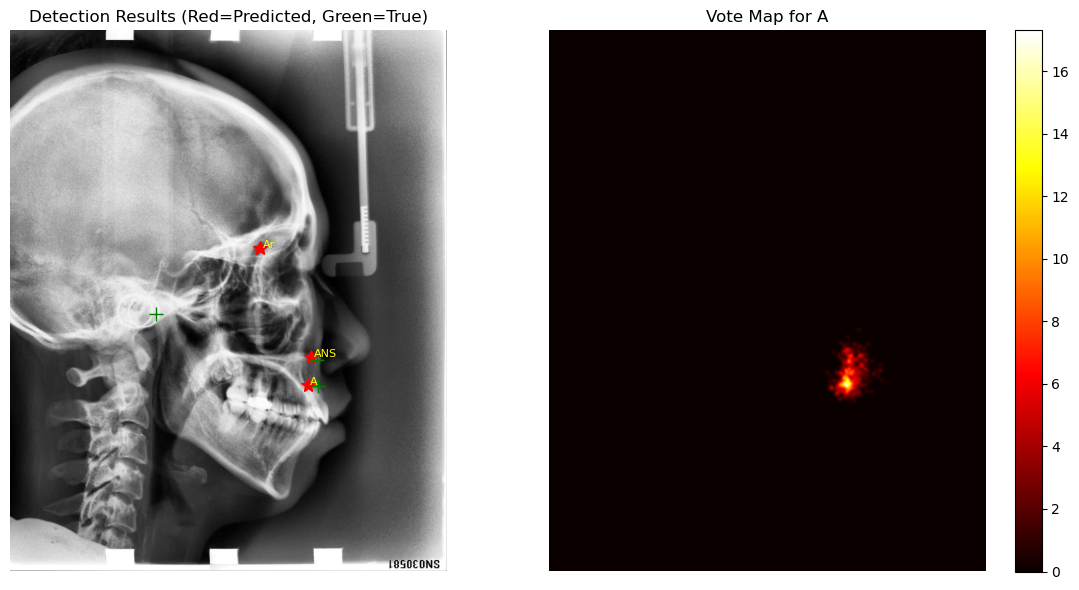

In [12]:
print("\n" + "="*60)
print("STEP 8: SINGLE IMAGE TEST")
print("="*60)

# Get first test image
test_sample = test_preprocessed[0]
test_image = test_sample['enhanced_image']

print(f"Testing on image: {test_sample['ceph_id']}")

# Detect all landmarks
detection_results = {}
for landmark_key in list(trainer.rf_models.keys())[:3]:  # Test first 3 landmarks
    print(f"\nDetecting landmark: {landmark_key}")
    
    if USE_COARSE_TO_FINE:
        position, vote_map = detector.coarse_to_fine_detection(test_image, landmark_key)
    else:
        position, vote_map = detector.detect_landmark_parallel(test_image, landmark_key, step_size=5)
    
    detection_results[landmark_key] = {
        'position': position,
        'vote_map': vote_map
    }
    
    # Calculate error if ground truth available
    if landmark_key in test_sample['normalized_landmarks']:
        true_pos = test_sample['normalized_landmarks'][landmark_key]
        error = np.sqrt((position[0] - true_pos[0])**2 + (position[1] - true_pos[1])**2)
        print(f"  Error: {error:.2f} pixels")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Image with detections
axes[0].imshow(test_image, cmap='gray')
for landmark_key, result in detection_results.items():
    pred_pos = result['position']
    axes[0].plot(pred_pos[0], pred_pos[1], 'r*', markersize=10)
    axes[0].text(pred_pos[0] + 5, pred_pos[1], landmark_key, color='yellow', fontsize=8)
    
    # Show true position
    if landmark_key in test_sample['normalized_landmarks']:
        true_pos = test_sample['normalized_landmarks'][landmark_key]
        axes[0].plot(true_pos[0], true_pos[1], 'g+', markersize=10)

axes[0].set_title('Detection Results (Red=Predicted, Green=True)')
axes[0].axis('off')

# Vote map for first landmark
first_landmark = list(detection_results.keys())[0]
im = axes[1].imshow(detection_results[first_landmark]['vote_map'], cmap='hot')
axes[1].set_title(f'Vote Map for {first_landmark}')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from scipy import stats

# Conversion factor
PIXEL_TO_MM = 0.1  # 0.1mm per pixel

"""
## 1. Complete Test Set Evaluation Function
"""

# %%
def evaluate_full_test_set(detector, test_preprocessed, use_coarse_to_fine=True, 
                          pixel_to_mm=0.1, sdr_thresholds_mm=[2, 2.5, 3, 4]):
    """
    Comprehensive evaluation on full test set with clinical metrics.
    
    Args:
        detector: OptimizedRFRVDetector instance
        test_preprocessed: List of preprocessed test images
        use_coarse_to_fine: Whether to use coarse-to-fine detection
        pixel_to_mm: Conversion factor (0.1mm per pixel)
        sdr_thresholds_mm: Success detection rate thresholds in mm
        
    Returns:
        Dictionary with all metrics and detailed results
    """
    
    print("="*70)
    print("FULL TEST SET EVALUATION")
    print("="*70)
    print(f"Test samples: {len(test_preprocessed)}")
    print(f"Landmarks: {len(detector.trainer.rf_models)}")
    print(f"Pixel to mm conversion: {pixel_to_mm} mm/pixel")
    print(f"Detection method: {'Coarse-to-fine' if use_coarse_to_fine else 'Single-stage'}")
    print("-"*70)
    
    # Store all errors
    all_errors_px = []
    all_errors_mm = []
    errors_by_landmark = {key: [] for key in detector.trainer.rf_models.keys()}
    errors_by_image = []
    
    # Detailed results storage
    detailed_results = []
    
    # Process each test image
    start_time = time.time()
    
    for img_idx, sample in enumerate(test_preprocessed):
        print(f"\nProcessing test image {img_idx+1}/{len(test_preprocessed)} (ID: {sample['ceph_id']})...")
        
        image = sample['enhanced_image']
        image_errors_px = []
        image_errors_mm = []
        
        # Detect each landmark
        for landmark_key in detector.trainer.rf_models.keys():
            if landmark_key not in sample['normalized_landmarks']:
                continue
            
            # Get ground truth
            true_pos = sample['normalized_landmarks'][landmark_key]
            
            # Detect landmark
            try:
                if use_coarse_to_fine:
                    predicted_pos, _ = detector.coarse_to_fine_detection(
                        image, landmark_key
                    )
                else:
                    predicted_pos, _ = detector.detect_landmark_parallel(
                        image, landmark_key, step_size=5
                    )
                
                # Calculate error in pixels
                error_px = np.sqrt((predicted_pos[0] - true_pos[0])**2 + 
                                  (predicted_pos[1] - true_pos[1])**2)
                
                # Convert to mm
                error_mm = error_px * pixel_to_mm
                
                # Store errors
                all_errors_px.append(error_px)
                all_errors_mm.append(error_mm)
                errors_by_landmark[landmark_key].append(error_mm)
                image_errors_px.append(error_px)
                image_errors_mm.append(error_mm)
                
                # Store detailed result
                detailed_results.append({
                    'image_id': sample['ceph_id'],
                    'landmark': landmark_key,
                    'true_x': true_pos[0],
                    'true_y': true_pos[1],
                    'pred_x': predicted_pos[0],
                    'pred_y': predicted_pos[1],
                    'error_px': error_px,
                    'error_mm': error_mm
                })
                
            except Exception as e:
                print(f"  Error detecting {landmark_key}: {str(e)}")
                continue
        
        # Store image-level statistics
        if image_errors_mm:
            errors_by_image.append({
                'image_id': sample['ceph_id'],
                'mean_error_mm': np.mean(image_errors_mm),
                'max_error_mm': np.max(image_errors_mm),
                'detected_landmarks': len(image_errors_mm)
            })
            
            print(f"  Image mean error: {np.mean(image_errors_mm):.2f}mm, "
                  f"Max: {np.max(image_errors_mm):.2f}mm")
    
    # Calculate overall metrics
    all_errors_px = np.array(all_errors_px)
    all_errors_mm = np.array(all_errors_mm)
    
    # Core metrics
    mse_px = np.mean(all_errors_px ** 2)
    mse_mm = np.mean(all_errors_mm ** 2)
    
    mae_px = np.mean(all_errors_px)
    mae_mm = np.mean(all_errors_mm)
    
    # Mean Radial Error (MRE) - same as MAE for Euclidean distance
    mre_px = mae_px  # For 2D landmarks, MRE equals MAE
    mre_mm = mae_mm
    
    # Additional metrics
    rmse_px = np.sqrt(mse_px)
    rmse_mm = np.sqrt(mse_mm)
    
    median_px = np.median(all_errors_px)
    median_mm = np.median(all_errors_mm)
    
    std_px = np.std(all_errors_px)
    std_mm = np.std(all_errors_mm)
    
    # Success Detection Rates (SDR)
    sdr = {}
    for threshold_mm in sdr_thresholds_mm:
        threshold_px = threshold_mm / pixel_to_mm
        success_rate = (all_errors_mm <= threshold_mm).mean() * 100
        sdr[f'SDR_{threshold_mm}mm'] = success_rate
    
    # Timing
    total_time = time.time() - start_time
    time_per_image = total_time / len(test_preprocessed)
    time_per_landmark = total_time / len(all_errors_mm) if len(all_errors_mm) > 0 else 0
    
    # Compile results
    results = {
        'overall_metrics': {
            'MSE_px': mse_px,
            'MSE_mm': mse_mm,
            'MAE_px': mae_px,
            'MAE_mm': mae_mm,
            'MRE_px': mre_px,
            'MRE_mm': mre_mm,
            'RMSE_px': rmse_px,
            'RMSE_mm': rmse_mm,
            'Median_px': median_px,
            'Median_mm': median_mm,
            'Std_px': std_px,
            'Std_mm': std_mm,
            'Min_error_mm': np.min(all_errors_mm),
            'Max_error_mm': np.max(all_errors_mm),
            'P95_mm': np.percentile(all_errors_mm, 95),
            'P99_mm': np.percentile(all_errors_mm, 99),
        },
        'sdr': sdr,
        'per_landmark': errors_by_landmark,
        'per_image': errors_by_image,
        'detailed_results': detailed_results,
        'timing': {
            'total_time_seconds': total_time,
            'time_per_image': time_per_image,
            'time_per_landmark': time_per_landmark
        },
        'data_info': {
            'n_test_images': len(test_preprocessed),
            'n_landmarks': len(detector.trainer.rf_models),
            'n_detections': len(all_errors_mm),
            'pixel_to_mm': pixel_to_mm
        }
    }
    
    return results

# %% [markdown]
"""
## 2. Run Evaluation
"""

# %%
# Run the evaluation
print("Starting full test set evaluation...")
evaluation_results = evaluate_full_test_set(
    detector=detector,
    test_preprocessed=test_preprocessed,
    use_coarse_to_fine=True,  # or False for single-stage
    pixel_to_mm=PIXEL_TO_MM,
    sdr_thresholds_mm=[2, 2.5, 3, 4]  # Clinical thresholds in mm
)

# %% [markdown]
"""
## 3. Display Results Summary
"""

# %%
def print_evaluation_summary(results):
    """Print formatted evaluation summary."""
    
    print("\n" + "="*70)
    print("EVALUATION RESULTS SUMMARY")
    print("="*70)
    
    # Overall metrics
    print("\n📊 OVERALL METRICS:")
    print("-"*40)
    metrics = results['overall_metrics']
    
    print(f"MSE (Mean Squared Error):")
    print(f"  Pixels: {metrics['MSE_px']:.2f}")
    print(f"  MM:     {metrics['MSE_mm']:.2f}")
    
    print(f"\nMAE (Mean Absolute Error):")
    print(f"  Pixels: {metrics['MAE_px']:.2f}")
    print(f"  MM:     {metrics['MAE_mm']:.2f}")
    
    print(f"\nMRE (Mean Radial Error):")
    print(f"  Pixels: {metrics['MRE_px']:.2f}")
    print(f"  MM:     {metrics['MRE_mm']:.2f}")
    
    print(f"\nRMSE (Root Mean Squared Error):")
    print(f"  Pixels: {metrics['RMSE_px']:.2f}")
    print(f"  MM:     {metrics['RMSE_mm']:.2f}")
    
    print(f"\nAdditional Statistics (mm):")
    print(f"  Median: {metrics['Median_mm']:.2f}")
    print(f"  Std Dev: {metrics['Std_mm']:.2f}")
    print(f"  Min: {metrics['Min_error_mm']:.2f}")
    print(f"  Max: {metrics['Max_error_mm']:.2f}")
    print(f"  95th percentile: {metrics['P95_mm']:.2f}")
    print(f"  99th percentile: {metrics['P99_mm']:.2f}")
    
    # Success Detection Rates
    print("\n🎯 SUCCESS DETECTION RATES (SDR):")
    print("-"*40)
    for threshold, rate in results['sdr'].items():
        threshold_val = threshold.replace('SDR_', '').replace('mm', '')
        print(f"  Within {threshold_val:>3}mm: {rate:6.2f}%")
    
    # The critical 2mm threshold
    if 'SDR_2mm' in results['sdr']:
        sdr_2mm = results['sdr']['SDR_2mm']
        print(f"\n⭐ Clinical Standard (2mm): {sdr_2mm:.2f}%")
        if sdr_2mm >= 75:
            print("   ✅ Meets clinical standards (>75%)")
        else:
            print(f"   ⚠️ Below clinical standards (need {75-sdr_2mm:.1f}% improvement)")
    
    # Timing
    print("\n⏱️ PERFORMANCE:")
    print("-"*40)
    print(f"  Total evaluation time: {results['timing']['total_time_seconds']:.1f} seconds")
    print(f"  Time per image: {results['timing']['time_per_image']:.1f} seconds")
    print(f"  Time per landmark: {results['timing']['time_per_landmark']:.2f} seconds")
    
    # Data info
    print("\n📋 DATASET INFO:")
    print("-"*40)
    print(f"  Test images: {results['data_info']['n_test_images']}")
    print(f"  Landmarks: {results['data_info']['n_landmarks']}")
    print(f"  Total detections: {results['data_info']['n_detections']}")

# Print the summary
print_evaluation_summary(evaluation_results)

# %% [markdown]
"""
## 4. Per-Landmark Analysis
"""

# %%
def analyze_per_landmark(results):
    """Analyze and display per-landmark performance."""
    
    print("\n" + "="*70)
    print("PER-LANDMARK ANALYSIS")
    print("="*70)
    
    landmark_stats = []
    
    for landmark, errors in results['per_landmark'].items():
        if errors:
            errors = np.array(errors)
            landmark_stats.append({
                'Landmark': landmark,
                'MAE_mm': np.mean(errors),
                'Median_mm': np.median(errors),
                'Std_mm': np.std(errors),
                'Max_mm': np.max(errors),
                'SDR_2mm_%': (errors <= 2).mean() * 100,
                'SDR_3mm_%': (errors <= 3).mean() * 100,
                'N_samples': len(errors)
            })
    
    # Create DataFrame and sort by MAE
    df_landmarks = pd.DataFrame(landmark_stats)
    df_landmarks = df_landmarks.sort_values('MAE_mm')
    
    # Display best and worst
    print("\n🏆 TOP 5 BEST PERFORMING LANDMARKS:")
    print("-"*50)
    print(df_landmarks[['Landmark', 'MAE_mm', 'SDR_2mm_%', 'SDR_3mm_%']].head().to_string(index=False))
    
    print("\n⚠️ TOP 5 MOST CHALLENGING LANDMARKS:")
    print("-"*50)
    print(df_landmarks[['Landmark', 'MAE_mm', 'SDR_2mm_%', 'SDR_3mm_%']].tail().to_string(index=False))
    
    return df_landmarks

# Analyze per-landmark
df_landmark_performance = analyze_per_landmark(evaluation_results)

# %% [markdown]
"""
## 5. Visualization of Results
"""

# %%
def visualize_evaluation_results(results, df_landmarks):
    """Create comprehensive visualization of evaluation results."""
    
    all_errors_mm = []
    for errors in results['per_landmark'].values():
        all_errors_mm.extend(errors)
    all_errors_mm = np.array(all_errors_mm)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Error Distribution Histogram
    ax1 = plt.subplot(2, 3, 1)
    ax1.hist(all_errors_mm, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    ax1.axvline(results['overall_metrics']['MAE_mm'], color='red', 
                linestyle='--', linewidth=2, label=f'MAE: {results["overall_metrics"]["MAE_mm"]:.2f}mm')
    ax1.axvline(results['overall_metrics']['Median_mm'], color='green', 
                linestyle='--', linewidth=2, label=f'Median: {results["overall_metrics"]["Median_mm"]:.2f}mm')
    ax1.axvline(2, color='orange', linestyle=':', linewidth=2, label='2mm threshold')
    ax1.set_xlabel('Error (mm)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Error Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Cumulative Distribution (SDR curve)
    ax2 = plt.subplot(2, 3, 2)
    sorted_errors = np.sort(all_errors_mm)
    cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
    ax2.plot(sorted_errors, cumulative, linewidth=2, color='blue')
    ax2.axvline(2, color='red', linestyle='--', alpha=0.7, label='2mm clinical threshold')
    ax2.axhline(results['sdr']['SDR_2mm'], color='red', linestyle=':', alpha=0.7)
    ax2.text(2.1, results['sdr']['SDR_2mm'], f'{results["sdr"]["SDR_2mm"]:.1f}%', fontsize=10)
    
    for threshold_mm in [3, 4]:
        if f'SDR_{threshold_mm}mm' in results['sdr']:
            ax2.axvline(threshold_mm, color='gray', linestyle=':', alpha=0.5)
            ax2.text(threshold_mm, 5, f'{threshold_mm}mm', fontsize=8, ha='center')
    
    ax2.set_xlabel('Error (mm)')
    ax2.set_ylabel('Cumulative Percentage (%)')
    ax2.set_title('Success Detection Rate Curve')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, min(10, max(sorted_errors))])
    ax2.legend()
    
    # 3. Box Plot by Landmark
    ax3 = plt.subplot(2, 3, 3)
    landmark_errors = [results['per_landmark'][lm] for lm in df_landmarks['Landmark'][:10] 
                       if results['per_landmark'][lm]]
    bp = ax3.boxplot(landmark_errors, labels=df_landmarks['Landmark'][:10], 
                     vert=True, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    ax3.axhline(2, color='red', linestyle='--', alpha=0.7, label='2mm threshold')
    ax3.set_ylabel('Error (mm)')
    ax3.set_title('Top 10 Landmarks - Error Distribution')
    ax3.grid(True, axis='y', alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Per-Landmark Bar Chart
    ax4 = plt.subplot(2, 3, 4)
    landmarks = df_landmarks['Landmark'].values
    mae_values = df_landmarks['MAE_mm'].values
    colors = ['green' if mae < 2 else 'orange' if mae < 3 else 'red' for mae in mae_values]
    bars = ax4.barh(range(len(landmarks)), mae_values, color=colors, edgecolor='black')
    ax4.set_yticks(range(len(landmarks)))
    ax4.set_yticklabels(landmarks, fontsize=8)
    ax4.axvline(2, color='red', linestyle='--', alpha=0.7, label='2mm threshold')
    ax4.set_xlabel('Mean Absolute Error (mm)')
    ax4.set_title('MAE by Landmark')
    ax4.grid(True, axis='x', alpha=0.3)
    ax4.legend()
    
    # 5. SDR Comparison
    ax5 = plt.subplot(2, 3, 5)
    thresholds = [float(k.replace('SDR_', '').replace('mm', '')) for k in results['sdr'].keys()]
    sdr_values = list(results['sdr'].values())
    ax5.bar(thresholds, sdr_values, color='skyblue', edgecolor='black', width=0.3)
    ax5.axhline(75, color='green', linestyle='--', alpha=0.7, label='75% target')
    ax5.set_xlabel('Threshold (mm)')
    ax5.set_ylabel('Success Rate (%)')
    ax5.set_title('Success Detection Rates')
    ax5.set_xticks(thresholds)
    ax5.grid(True, axis='y', alpha=0.3)
    ax5.legend()
    
    # Add value labels on bars
    for i, (t, v) in enumerate(zip(thresholds, sdr_values)):
        ax5.text(t, v + 1, f'{v:.1f}%', ha='center', fontsize=9)
    
    # 6. Q-Q Plot (check for normality)
    ax6 = plt.subplot(2, 3, 6)
    stats.probplot(all_errors_mm, dist="norm", plot=ax6)
    ax6.set_title('Q-Q Plot (Normality Check)')
    ax6.grid(True, alpha=0.3)
    
    plt.suptitle('RFRV Detection Performance - Comprehensive Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

# Create visualizations
fig = visualize_evaluation_results(evaluation_results, df_landmark_performance)

# %% [markdown]
"""
## 6. Export Results to CSV
"""

# %%
def export_evaluation_results(results, df_landmarks, output_prefix='evaluation'):
    """Export evaluation results to CSV files."""
    
    # 1. Overall metrics
    overall_df = pd.DataFrame([results['overall_metrics']])
    overall_df['SDR_2mm_%'] = results['sdr']['SDR_2mm']
    overall_df['SDR_3mm_%'] = results['sdr']['SDR_3mm']
    overall_df['SDR_4mm_%'] = results['sdr']['SDR_4mm']
    overall_df.to_csv(f'{output_prefix}_overall_metrics.csv', index=False)
    print(f"✓ Saved overall metrics to {output_prefix}_overall_metrics.csv")
    
    # 2. Per-landmark metrics
    df_landmarks.to_csv(f'{output_prefix}_per_landmark.csv', index=False)
    print(f"✓ Saved per-landmark metrics to {output_prefix}_per_landmark.csv")
    
    # 3. Detailed results
    df_detailed = pd.DataFrame(results['detailed_results'])
    df_detailed.to_csv(f'{output_prefix}_detailed_results.csv', index=False)
    print(f"✓ Saved detailed results to {output_prefix}_detailed_results.csv")
    
    # 4. Per-image summary
    df_images = pd.DataFrame(results['per_image'])
    df_images.to_csv(f'{output_prefix}_per_image.csv', index=False)
    print(f"✓ Saved per-image summary to {output_prefix}_per_image.csv")
    
    return overall_df

# Export results
overall_metrics_df = export_evaluation_results(
    evaluation_results, 
    df_landmark_performance,
    output_prefix='rfrv_test_evaluation'
)

# %% [markdown]
"""
## 7. Final Summary for Reporting
"""

# %%
print("\n" + "="*70)
print("FINAL SUMMARY FOR REPORTING")
print("="*70)

print(f"""
📊 Key Metrics (with {PIXEL_TO_MM}mm/pixel conversion):
----------------------------------------
• MSE: {evaluation_results['overall_metrics']['MSE_mm']:.2f} mm²
• MAE: {evaluation_results['overall_metrics']['MAE_mm']:.2f} mm
• MRE: {evaluation_results['overall_metrics']['MRE_mm']:.2f} mm
• RMSE: {evaluation_results['overall_metrics']['RMSE_mm']:.2f} mm

🎯 Clinical Performance:
----------------------------------------
• Success Rate (≤2mm): {evaluation_results['sdr']['SDR_2mm']:.1f}%
• Success Rate (≤2.5mm): {evaluation_results['sdr']['SDR_2.5mm']:.1f}%
• Success Rate (≤3mm): {evaluation_results['sdr']['SDR_3mm']:.1f}%
• Success Rate (≤4mm): {evaluation_results['sdr']['SDR_4mm']:.1f}%

📈 Distribution:
----------------------------------------
• Median Error: {evaluation_results['overall_metrics']['Median_mm']:.2f} mm
• 95th Percentile: {evaluation_results['overall_metrics']['P95_mm']:.2f} mm
• Max Error: {evaluation_results['overall_metrics']['Max_error_mm']:.2f} mm

⏱️ Speed:
----------------------------------------
• Detection time per image: {evaluation_results['timing']['time_per_image']:.1f} seconds
• Detection time per landmark: {evaluation_results['timing']['time_per_landmark']:.2f} seconds

📋 Test Set:
----------------------------------------
• Images evaluated: {evaluation_results['data_info']['n_test_images']}
• Landmarks per image: {evaluation_results['data_info']['n_landmarks']}
• Total detections: {evaluation_results['data_info']['n_detections']}
""")

# Clinical assessment
if evaluation_results['sdr']['SDR_2mm'] >= 75:
    print("\n✅ CLINICAL ASSESSMENT: Model meets clinical standards (>75% within 2mm)")
else:
    improvement_needed = 75 - evaluation_results['sdr']['SDR_2mm']
    print(f"\n⚠️ CLINICAL ASSESSMENT: Model needs {improvement_needed:.1f}% improvement to meet clinical standards")

Starting full test set evaluation...
FULL TEST SET EVALUATION
Test samples: 80
Landmarks: 19
Pixel to mm conversion: 0.1 mm/pixel
Detection method: Coarse-to-fine
----------------------------------------------------------------------

Processing test image 1/80 (ID: 213)...

=== Coarse-to-Fine Detection for 'A' ===
Stage 1: Coarse detection...
Detecting 'A' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:11<00:00,  5.72it/s]


  Detection completed in 28.0 seconds
  Detected position: (560, 615)
  Peak confidence: 5.29
Stage 2: Fine detection around (560, 615)...
Detecting 'A' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<00:00, 19733.26it/s]


  Detection completed in 7.3 seconds
  Detected position: (545, 650)
  Peak confidence: 17.31
Final position: (545, 650)

=== Coarse-to-Fine Detection for 'ANS' ===
Stage 1: Coarse detection...
Detecting 'ANS' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:09<00:00,  6.87it/s]


  Detection completed in 24.2 seconds
  Detected position: (578, 607)
  Peak confidence: 5.19
Stage 2: Fine detection around (578, 607)...
Detecting 'ANS' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<?, ?it/s]


  Detection completed in 6.4 seconds
  Detected position: (551, 599)
  Peak confidence: 16.62
Final position: (551, 599)

=== Coarse-to-Fine Detection for 'Ar' ===
Stage 1: Coarse detection...
Detecting 'Ar' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:08<00:00,  8.35it/s]


  Detection completed in 22.8 seconds
  Detected position: (454, 417)
  Peak confidence: 4.36
Stage 2: Fine detection around (454, 417)...
Detecting 'Ar' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<00:00, 9386.38it/s]


  Detection completed in 6.4 seconds
  Detected position: (458, 398)
  Peak confidence: 9.89
Final position: (458, 398)

=== Coarse-to-Fine Detection for 'B' ===
Stage 1: Coarse detection...
Detecting 'B' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:08<00:00,  8.37it/s]


  Detection completed in 22.9 seconds
  Detected position: (525, 783)
  Peak confidence: 4.53
Stage 2: Fine detection around (525, 783)...
Detecting 'B' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<?, ?it/s]


  Detection completed in 6.3 seconds
  Detected position: (524, 786)
  Peak confidence: 13.73
Final position: (524, 786)

=== Coarse-to-Fine Detection for 'Gn' ===
Stage 1: Coarse detection...
Detecting 'Gn' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:08<00:00,  8.15it/s]


  Detection completed in 22.7 seconds
  Detected position: (504, 849)
  Peak confidence: 7.48
Stage 2: Fine detection around (504, 849)...
Detecting 'Gn' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<?, ?it/s]


  Detection completed in 7.0 seconds
  Detected position: (505, 865)
  Peak confidence: 19.23
Final position: (505, 865)

=== Coarse-to-Fine Detection for 'Go' ===
Stage 1: Coarse detection...
Detecting 'Go' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:08<00:00,  8.23it/s]


  Detection completed in 22.6 seconds
  Detected position: (283, 701)
  Peak confidence: 4.76
Stage 2: Fine detection around (283, 701)...
Detecting 'Go' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<00:00, 12662.05it/s]


  Detection completed in 6.7 seconds
  Detected position: (280, 695)
  Peak confidence: 23.02
Final position: (280, 695)

=== Coarse-to-Fine Detection for 'LIT' ===
Stage 1: Coarse detection...
Detecting 'LIT' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:08<00:00,  7.97it/s]


  Detection completed in 22.7 seconds
  Detected position: (564, 523)
  Peak confidence: 4.59
Stage 2: Fine detection around (564, 523)...
Detecting 'LIT' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<?, ?it/s]


  Detection completed in 5.8 seconds
  Detected position: (546, 537)
  Peak confidence: 17.04
Final position: (546, 537)

=== Coarse-to-Fine Detection for 'Li' ===
Stage 1: Coarse detection...
Detecting 'Li' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:07<00:00,  9.34it/s]


  Detection completed in 20.3 seconds
  Detected position: (591, 792)
  Peak confidence: 6.03
Stage 2: Fine detection around (591, 792)...
Detecting 'Li' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<00:00, 5362.53it/s]


  Detection completed in 5.7 seconds
  Detected position: (604, 764)
  Peak confidence: 28.97
Final position: (604, 764)

=== Coarse-to-Fine Detection for 'Ls' ===
Stage 1: Coarse detection...
Detecting 'Ls' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:07<00:00,  9.38it/s]


  Detection completed in 20.6 seconds
  Detected position: (622, 693)
  Peak confidence: 4.67
Stage 2: Fine detection around (622, 693)...
Detecting 'Ls' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<00:00, 19793.79it/s]


  Detection completed in 6.0 seconds
  Detected position: (620, 704)
  Peak confidence: 18.99
Final position: (620, 704)

=== Coarse-to-Fine Detection for 'Me' ===
Stage 1: Coarse detection...
Detecting 'Me' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:07<00:00,  9.04it/s]


  Detection completed in 20.5 seconds
  Detected position: (490, 856)
  Peak confidence: 5.53
Stage 2: Fine detection around (490, 856)...
Detecting 'Me' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<00:00, 5790.84it/s]


  Detection completed in 5.8 seconds
  Detected position: (504, 866)
  Peak confidence: 21.97
Final position: (504, 866)

=== Coarse-to-Fine Detection for 'N' ===
Stage 1: Coarse detection...
Detecting 'N' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:08<00:00,  8.23it/s]


  Detection completed in 23.0 seconds
  Detected position: (558, 404)
  Peak confidence: 7.43
Stage 2: Fine detection around (558, 404)...
Detecting 'N' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<?, ?it/s]


  Detection completed in 5.9 seconds
  Detected position: (557, 395)
  Peak confidence: 19.88
Final position: (557, 395)

=== Coarse-to-Fine Detection for 'Or' ===
Stage 1: Coarse detection...
Detecting 'Or' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:07<00:00,  8.65it/s]


  Detection completed in 20.4 seconds
  Detected position: (248, 684)
  Peak confidence: 4.43
Stage 2: Fine detection around (248, 684)...
Detecting 'Or' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<?, ?it/s]


  Detection completed in 5.8 seconds
  Detected position: (255, 721)
  Peak confidence: 9.01
Final position: (255, 721)

=== Coarse-to-Fine Detection for 'PNS' ===
Stage 1: Coarse detection...
Detecting 'PNS' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:07<00:00,  9.17it/s]


  Detection completed in 20.8 seconds
  Detected position: (126, 623)
  Peak confidence: 3.99
Stage 2: Fine detection around (126, 623)...
Detecting 'PNS' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<00:00, 19968.12it/s]


  Detection completed in 5.7 seconds
  Detected position: (122, 633)
  Peak confidence: 8.43
Final position: (122, 633)

=== Coarse-to-Fine Detection for 'Po' ===
Stage 1: Coarse detection...
Detecting 'Po' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:07<00:00,  9.42it/s]


  Detection completed in 20.2 seconds
  Detected position: (247, 508)
  Peak confidence: 4.23
Stage 2: Fine detection around (247, 508)...
Detecting 'Po' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<00:00, 19996.68it/s]


  Detection completed in 5.7 seconds
  Detected position: (244, 507)
  Peak confidence: 16.03
Final position: (244, 507)

=== Coarse-to-Fine Detection for 'Pog' ===
Stage 1: Coarse detection...
Detecting 'Pog' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:07<00:00,  9.30it/s]


  Detection completed in 20.7 seconds
  Detected position: (541, 824)
  Peak confidence: 6.33
Stage 2: Fine detection around (541, 824)...
Detecting 'Pog' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<?, ?it/s]


  Detection completed in 6.0 seconds
  Detected position: (516, 844)
  Peak confidence: 30.37
Final position: (516, 844)

=== Coarse-to-Fine Detection for 'Pos' ===
Stage 1: Coarse detection...
Detecting 'Pos' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:07<00:00,  8.92it/s]


  Detection completed in 21.5 seconds
  Detected position: (564, 852)
  Peak confidence: 6.68
Stage 2: Fine detection around (564, 852)...
Detecting 'Pos' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<00:00, 16747.07it/s]


  Detection completed in 5.9 seconds
  Detected position: (581, 829)
  Peak confidence: 25.29
Final position: (581, 829)

=== Coarse-to-Fine Detection for 'S' ===
Stage 1: Coarse detection...
Detecting 'S' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:07<00:00,  9.05it/s]


  Detection completed in 20.9 seconds
  Detected position: (345, 402)
  Peak confidence: 4.71
Stage 2: Fine detection around (345, 402)...
Detecting 'S' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<00:00, 19968.12it/s]


  Detection completed in 5.8 seconds
  Detected position: (350, 417)
  Peak confidence: 11.20
Final position: (350, 417)

=== Coarse-to-Fine Detection for 'Sn' ===
Stage 1: Coarse detection...
Detecting 'Sn' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:07<00:00,  9.26it/s]


  Detection completed in 20.5 seconds
  Detected position: (614, 650)
  Peak confidence: 6.26
Stage 2: Fine detection around (614, 650)...
Detecting 'Sn' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<00:00, 20006.22it/s]


  Detection completed in 5.5 seconds
  Detected position: (609, 636)
  Peak confidence: 19.00
Final position: (609, 636)

=== Coarse-to-Fine Detection for 'UIT' ===
Stage 1: Coarse detection...
Detecting 'UIT' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:06<00:00,  9.76it/s]


  Detection completed in 19.6 seconds
  Detected position: (581, 711)
  Peak confidence: 5.26
Stage 2: Fine detection around (581, 711)...
Detecting 'UIT' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<?, ?it/s]


  Detection completed in 5.5 seconds
  Detected position: (594, 711)
  Peak confidence: 14.73
Final position: (594, 711)
  Image mean error: 7.00mm, Max: 34.28mm

Processing test image 2/80 (ID: 296)...

=== Coarse-to-Fine Detection for 'A' ===
Stage 1: Coarse detection...
Detecting 'A' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:06<00:00,  9.84it/s]


  Detection completed in 19.5 seconds
  Detected position: (588, 797)
  Peak confidence: 3.96
Stage 2: Fine detection around (588, 797)...
Detecting 'A' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<?, ?it/s]


  Detection completed in 5.4 seconds
  Detected position: (623, 769)
  Peak confidence: 10.95
Final position: (623, 769)

=== Coarse-to-Fine Detection for 'ANS' ===
Stage 1: Coarse detection...
Detecting 'ANS' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:06<00:00,  9.85it/s]


  Detection completed in 19.9 seconds
  Detected position: (620, 608)
  Peak confidence: 4.17
Stage 2: Fine detection around (620, 608)...
Detecting 'ANS' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<?, ?it/s]


  Detection completed in 5.9 seconds
  Detected position: (596, 611)
  Peak confidence: 11.47
Final position: (596, 611)

=== Coarse-to-Fine Detection for 'Ar' ===
Stage 1: Coarse detection...
Detecting 'Ar' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:07<00:00,  9.16it/s]


  Detection completed in 21.0 seconds
  Detected position: (289, 553)
  Peak confidence: 4.66
Stage 2: Fine detection around (289, 553)...
Detecting 'Ar' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<00:00, 20044.46it/s]


  Detection completed in 5.8 seconds
  Detected position: (282, 555)
  Peak confidence: 12.44
Final position: (282, 555)

=== Coarse-to-Fine Detection for 'B' ===
Stage 1: Coarse detection...
Detecting 'B' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:07<00:00,  9.41it/s]


  Detection completed in 20.5 seconds
  Detected position: (603, 761)
  Peak confidence: 5.20
Stage 2: Fine detection around (603, 761)...
Detecting 'B' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<00:00, 31289.10it/s]


  Detection completed in 5.8 seconds
  Detected position: (608, 761)
  Peak confidence: 19.23
Final position: (608, 761)

=== Coarse-to-Fine Detection for 'Gn' ===
Stage 1: Coarse detection...
Detecting 'Gn' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:07<00:00,  8.93it/s]


  Detection completed in 20.7 seconds
  Detected position: (594, 824)
  Peak confidence: 5.96
Stage 2: Fine detection around (594, 824)...
Detecting 'Gn' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<?, ?it/s]


  Detection completed in 6.0 seconds
  Detected position: (601, 827)
  Peak confidence: 23.75
Final position: (601, 827)

=== Coarse-to-Fine Detection for 'Go' ===
Stage 1: Coarse detection...
Detecting 'Go' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:07<00:00,  9.31it/s]


  Detection completed in 20.6 seconds
  Detected position: (633, 209)
  Peak confidence: 4.24
Stage 2: Fine detection around (633, 209)...
Detecting 'Go' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<?, ?it/s]


  Detection completed in 5.8 seconds
  Detected position: (623, 194)
  Peak confidence: 19.77
Final position: (623, 194)

=== Coarse-to-Fine Detection for 'LIT' ===
Stage 1: Coarse detection...
Detecting 'LIT' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows: 100%|██████████| 67/67 [00:07<00:00,  9.00it/s]


  Detection completed in 20.1 seconds
  Detected position: (627, 689)
  Peak confidence: 4.76
Stage 2: Fine detection around (627, 689)...
Detecting 'LIT' with parallel processing...
  Using 21 CPU cores
  Grid size: 20 x 20 = 400 points


Processing rows: 100%|██████████| 20/20 [00:00<00:00, 11954.69it/s]


  Detection completed in 5.8 seconds
  Detected position: (655, 712)
  Peak confidence: 14.94
Final position: (655, 712)

=== Coarse-to-Fine Detection for 'Li' ===
Stage 1: Coarse detection...
Detecting 'Li' with parallel processing...
  Using 21 CPU cores
  Grid size: 54 x 67 = 3618 points


Processing rows:  63%|██████▎   | 42/67 [00:01<00:00, 28.93it/s]